## **Division Folders Train/Test Alearotio**

In [2]:
import os
import pandas as pd
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### **Rutas**

In [3]:
base_dir = os.getcwd() 
folder_Images = os.path.join(base_dir, 'Images')
folder_Train = os.path.join(base_dir, 'Train')
folder_Test = os.path.join(base_dir, 'Test')

os.makedirs(folder_Train, exist_ok=True)
os.makedirs(folder_Test, exist_ok=True)

### **Limpiar contenido de Train y Test en cada ejecución**


In [4]:
for folder in [folder_Train, folder_Test]:
    for category in os.listdir(folder):
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path):
            shutil.rmtree(category_path)

### **Crear dataset de Train y Test con 60 y 6 imágenes por categoría respectivamente**


In [5]:
categories = os.listdir(folder_Images)
train_data = []
test_data = []

for category in categories:
    category_path = os.path.join(folder_Images, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        
        selected_images = np.random.choice(images, 66, replace=False)
        
        train_images = selected_images[:60]
        test_images = selected_images[60:]
        
        train_category_folder = os.path.join(folder_Train, category)
        test_category_folder = os.path.join(folder_Test, category)
        os.makedirs(train_category_folder, exist_ok=True)
        os.makedirs(test_category_folder, exist_ok=True)
        
        for idx, image_name in enumerate(train_images, start=1):
            src_path = os.path.join(category_path, image_name)
            dst_path = os.path.join(train_category_folder, f"{idx}_{category}.jpg")
            shutil.copy(src_path, dst_path)
            train_data.append({"filename": f"{idx}_{category}.jpg", "target": category})
        
        for idx, image_name in enumerate(test_images, start=1):
            src_path = os.path.join(category_path, image_name)
            dst_path = os.path.join(test_category_folder, f"{idx}_{category}.jpg")
            shutil.copy(src_path, dst_path)
            test_data.append({"filename": f"{idx}_{category}.jpg", "target": category})

### **Guardar los datasets en CSV**

In [6]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
train_df.to_csv('train_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

print("El dataset ha sido generado y guardado en train_dataset.csv y test_dataset.csv.")


El dataset ha sido generado y guardado en train_dataset.csv y test_dataset.csv.


## **Carga X_train, y_train, X_test, y_test**

In [7]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### **Tamaño de las imágenes**


In [8]:
img_size = (128, 128)

### **Cargar imágenes y etiquetas a partir del CSV**


In [9]:
def load_images_from_df(df, folder):
    images = []
    labels = []
    for index, row in df.iterrows():
        class_name = row['target']  
        img_path = os.path.join(folder, class_name, row['filename'])  
        try:
            img = load_img(img_path, target_size=img_size)  
            img_array = img_to_array(img) / 255.0  
            images.append(img_array)
            labels.append(class_name)
        except FileNotFoundError:
            print(f"El archivo no fue encontrado: {img_path}")
    return np.array(images), np.array(labels)

train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train, y_train = load_images_from_df(train_df, folder_Train)
X_test, y_test = load_images_from_df(test_df, folder_Test)

## **Preprocesamiento**

In [10]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [11]:
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [12]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [13]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10) 
y_test = to_categorical(y_test, num_classes=10)

In [14]:
print(f"Medidas Datos Train: {X_train.shape}")
print(f"Medidas Target Train: {y_train.shape}")
print(f"Medidas Datos Test: {X_test.shape}")
print(f"Medidas Target Test: {y_test.shape}")

Medidas Datos Train: (600, 128, 128, 3)
Medidas Target Train: (600, 10)
Medidas Datos Test: (60, 128, 128, 3)
Medidas Target Test: (60, 10)


## **Modelos** 

### **VGG19**

In [18]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers[:-4]: 
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  
x = Dropout(0.3)(x)  
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])


Epoch 1/25
19/19 [==============================] - 31s 2s/step - loss: 3.7868 - accuracy: 0.1033 - val_loss: 3.4559 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/25
19/19 [==============================] - 27s 1s/step - loss: 3.3296 - accuracy: 0.2167 - val_loss: 3.1796 - val_accuracy: 0.3167 - lr: 1.0000e-04
Epoch 3/25
19/19 [==============================] - 28s 1s/step - loss: 2.9867 - accuracy: 0.3500 - val_loss: 2.9586 - val_accuracy: 0.4333 - lr: 1.0000e-04
Epoch 4/25
19/19 [==============================] - 28s 1s/step - loss: 2.6342 - accuracy: 0.4833 - val_loss: 2.6349 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 5/25
19/19 [==============================] - 28s 1s/step - loss: 2.2446 - accuracy: 0.5900 - val_loss: 2.4077 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 6/25
19/19 [==============================] - 28s 1s/step - loss: 1.8921 - accuracy: 0.7133 - val_loss: 2.2058 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 7/25
19/19 [==============================] - 29s 2s

In [19]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")

2/2 [==============================] - 2s 1s/step - loss: 2.0817 - accuracy: 0.7000
Precisión en el conjunto de prueba: 70.00%


1/1 [==============================] - 0s 377ms/step


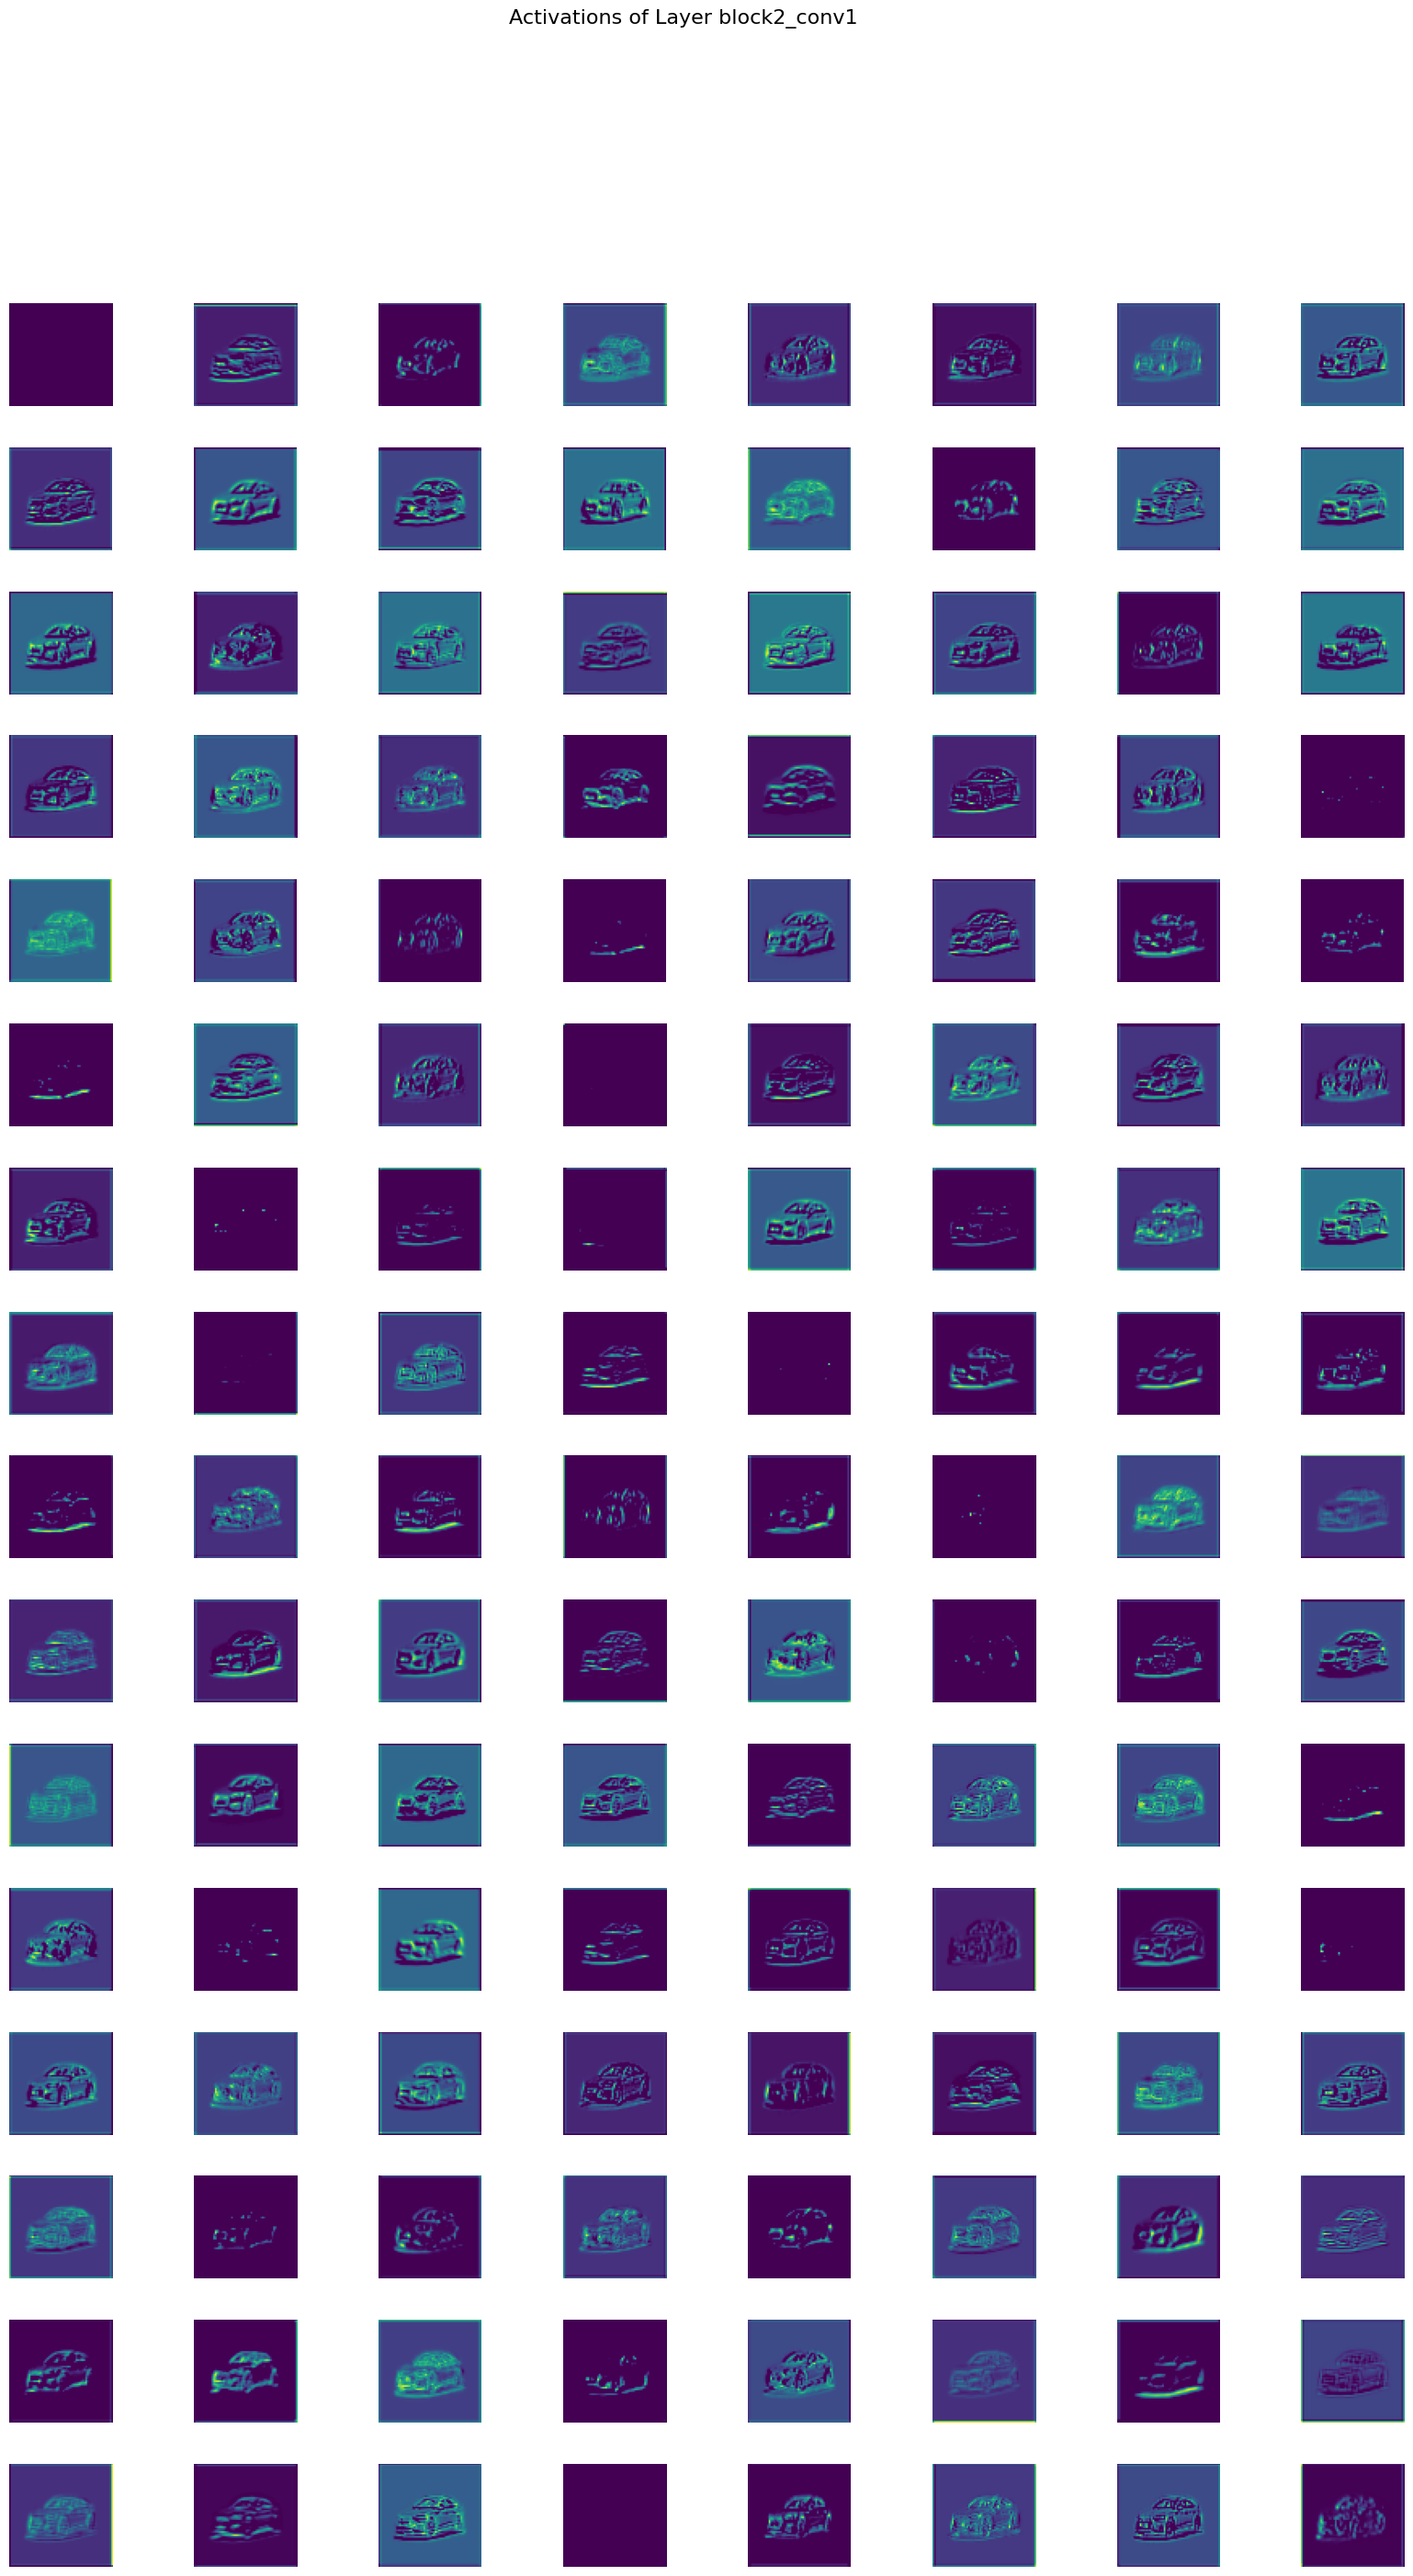

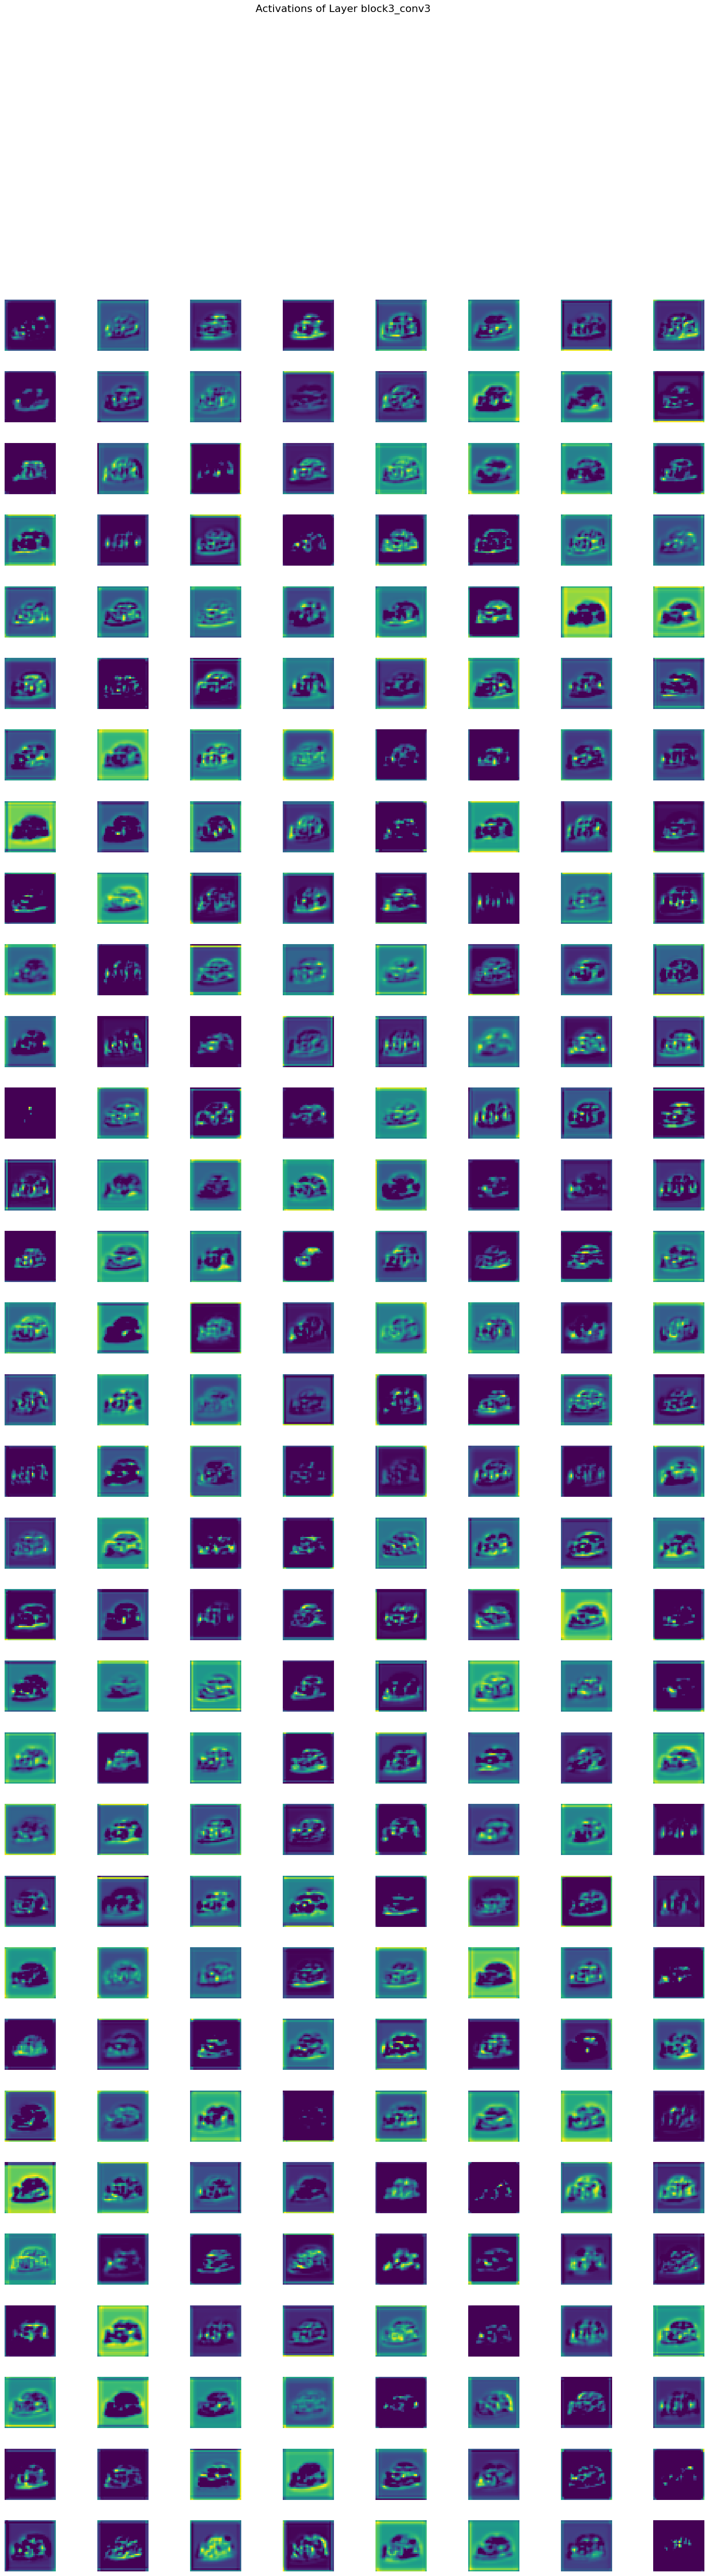

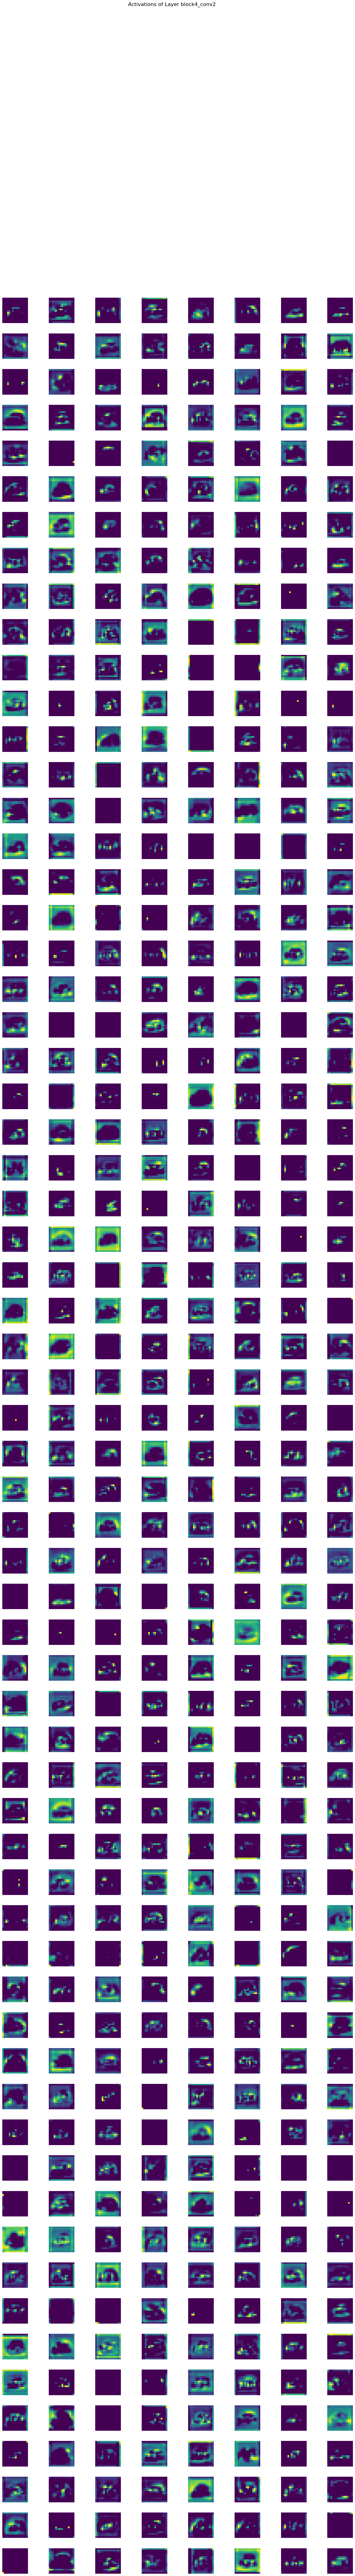

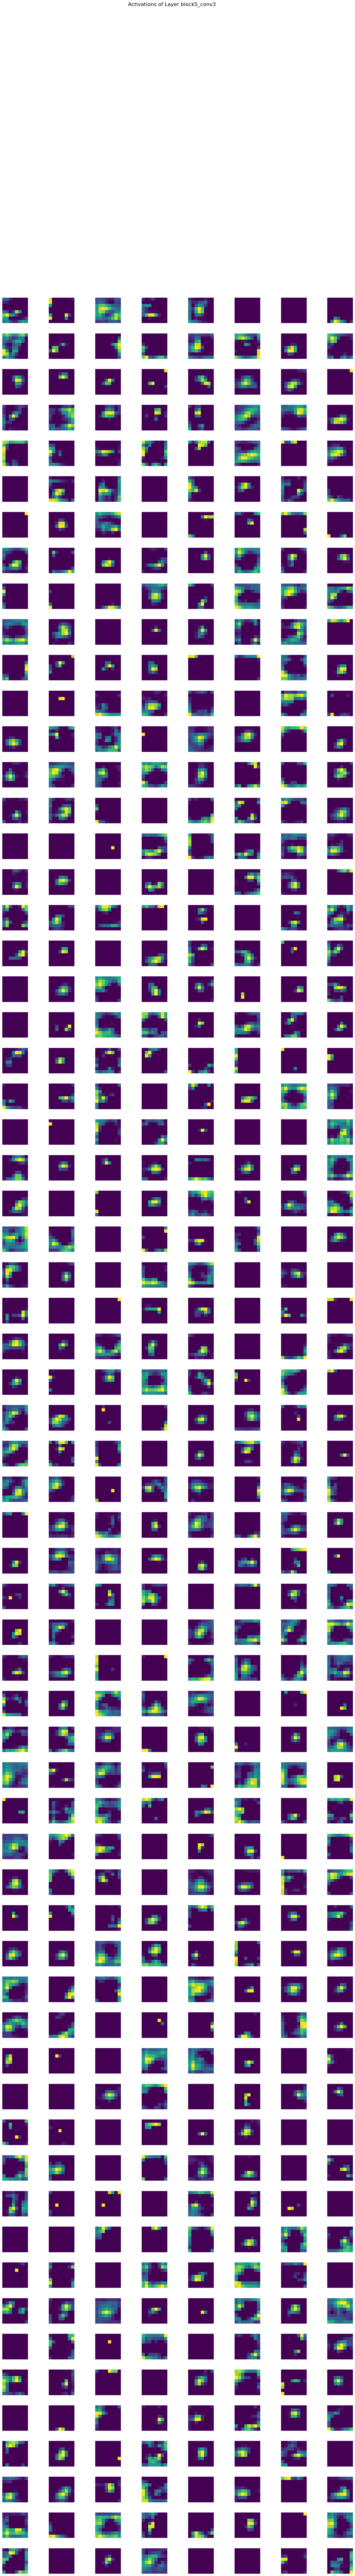

In [17]:
import matplotlib.pyplot as plt 

def visualize_activations_from_test_set(model, X_test, layer_indices, num_images=5):
    layer_outputs = [model.layers[i].output for i in layer_indices]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    activations = activation_model.predict(X_test[:num_images])  

    for layer_index, activation in zip(layer_indices, activations):
        num_filters = activation.shape[-1]
        cols = 8  
        rows = (num_filters + cols - 1) // cols  

        fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))
        fig.suptitle(f'Activations of Layer {model.layers[layer_index].name}', fontsize=16)

        for filter_index in range(num_filters):
            for img_index in range(num_images):
                ax_index = img_index * num_filters + filter_index
                if ax_index < rows * cols:  
                    ax = axes.flatten()[ax_index]
                    ax.imshow(activation[img_index, :, :, filter_index], cmap='viridis')
                    ax.axis('off')
                else:
                    break  
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

layer_indices = [4, 9, 13, 19]  
num_images_to_visualize = 3  
visualize_activations_from_test_set(model, X_test, layer_indices, num_images=num_images_to_visualize)


Capas Convolucionales: VGG19 utiliza bloques de capas convolucionales para extraer características de las imágenes. Hay 19 capas en total (de ahí el nombre "19"), y la red sigue un diseño consistente: apila varias capas convolucionales de 3x3 píxeles una encima de otra y luego reduce el tamaño de la imagen usando capas de max-pooling.

Capas de Pooling: Después de cada grupo de capas convolucionales, se usa una capa de max-pooling, que reduce la resolución de la imagen pero mantiene las características más importantes. Esto hace que la red sea más eficiente y menos sensible a pequeñas variaciones en la imagen.

Capas Completamente Conectadas: Al final de las capas convolucionales, hay tres capas completamente conectadas, donde cada neurona está conectada a todas las neuronas de la capa anterior. Estas capas toman las características extraídas por las capas convolucionales y determinan a qué clase pertenece la imagen.

Función de Activación: Utiliza la función de activación ReLU (Rectified Linear Unit) en las capas convolucionales, lo que ayuda a que la red aprenda representaciones complejas al hacer los cálculos no lineales.

Salida (Softmax): La última capa de VGG19 es una capa de softmax, que convierte los resultados en probabilidades. Así, la red calcula la probabilidad de que la imagen pertenezca a cada una de las posibles categorías.

Sin embargo como observamos con la impresion de los filtros de algunas de las capas VGG19 dado su gran complejidad y su gran catidad de capas en las que se reducen tanto las imagenes nos da resltados muy malos puiesto que realmete comom vemos terminamos con imagenes que practicamente no  nos dicen nada relevante 